In [121]:
import sys
# sys.path.insert(0, "./")
# sys.path.insert(0, "../../")
import torch
from torch.utils.data import Dataset
from utils_suboptimal import *
import random
import matplotlib.pyplot as plt

from torchvision.models import resnet50, resnet18
import argparse
import traceback
import seaborn as sns
import numpy as np
import ast

In [122]:
GRID_SIZE =6
experiment_label ="ALL_MODS_test"
cost = 0
def read_csv(filename):
    """
    Reads numbers from a CSV file and returns them as a list of lists.

    Args:
    filename (str): The name of the CSV file.

    Returns:
    list of lists: Each sublist contains numbers from a row in the CSV file.
    """
    data = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Convert each string in the row to an integer
            number_row = [ast.literal_eval(item) for item in row]
            data.append(number_row)
    return data 

In [123]:
true_wcds = read_csv(f"data/grid{GRID_SIZE}/true_wcds_{GRID_SIZE}_{experiment_label}.csv")
pred_wcds = read_csv(f"data/grid{GRID_SIZE}/pred_wcds_{GRID_SIZE}_{experiment_label}.csv")
len(true_wcds[0]),len(pred_wcds[0])

(1834, 1834)

Text(0, 0.5, 'True WCD')

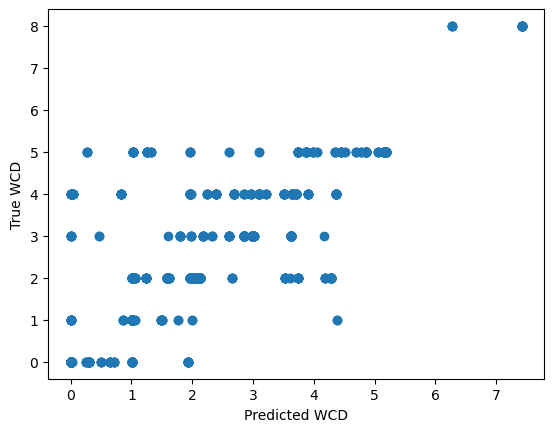

In [124]:
plt.scatter(pred_wcds[0],true_wcds[0])
plt.xlabel("Predicted WCD")
plt.ylabel("True WCD")

In [125]:
with open(f"data/grid{GRID_SIZE}/initial_envs_{GRID_SIZE}_{experiment_label}.pkl", "rb") as f:
    loaded_dataset = pickle.load(f)
    x_data = []
    y_data = []
    for i in range(loaded_dataset. __len__()):
        
        x_data.append(loaded_dataset[i][0].unsqueeze(0))
        y_data.append(loaded_dataset[i][1].unsqueeze(0))

    x_init_data = torch.cat(x_data).numpy()
    y_init_data = torch.cat(y_data).numpy()

/storage1/fs1/chien-ju.ho/Active/robert/projects/Gridworld MDP/suboptimal/utils_suboptimal.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[idx], dtype=torch.float32)
/storage1/fs1/chien-ju.ho/Active/robert/projects/Gridworld MDP/suboptimal/utils_suboptimal.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.Y[idx], dtype=torch.float32)


In [126]:
model = torch.load(f"models/wcd_nn_model_{GRID_SIZE}_best.pt")
    
model = model.cuda().eval()

In [127]:
with open(f"data/grid{GRID_SIZE}/final_envs_{GRID_SIZE}_{experiment_label}.pkl", "rb") as f:
    loaded_dataset = pickle.load(f)
    x_data = []
    y_data = []
    for i in range(loaded_dataset. __len__()):
        
        x_data.append(loaded_dataset[i][0].unsqueeze(0))
        y_data.append(loaded_dataset[i][1].unsqueeze(0))

    x_final_data = torch.cat(x_data).numpy()
    y_final_data = torch.cat(y_data).numpy()

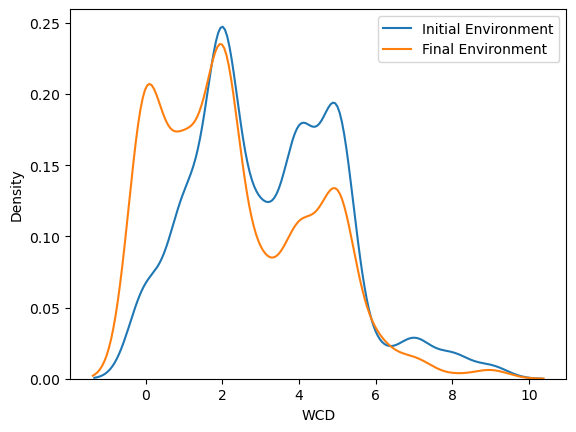

In [128]:
sns.kdeplot(y_init_data,label="Initial Environment")
sns.kdeplot(y_final_data,label="Final Environment")
plt.xlabel("WCD")
plt.legend()

In [129]:
def find_ranges(gamma, ranges):
    in_range = None
    not_in_range = None

    for r in ranges:
        if r[0] < gamma < r[1]:
            in_range = r
        else:
            # Select the first range in which gamma does not fall
            if not_in_range is None:
                not_in_range = r

    return in_range, not_in_range

# Example usage
gamma_value = 0.8 


In [130]:
# for i in range(0,2000,100):
#     print(compute_true_wcd(x_final_data[i])-y_final_data[i])

In [131]:
# Successful environments
x_final_good = x_final_data[y_final_data<y_init_data]
y_final_good = y_final_data[y_final_data<y_init_data]

x_init_good = x_init_data[y_final_data<y_init_data]
y_init_good = y_init_data[y_final_data<y_init_data]

print("Percentage reduced",y_init_good.shape[0]/y_init_data.shape[0])

Percentage reduced 0.26516700749829586


In [132]:
(y_init_good-y_final_good).mean(), (y_init_good-y_final_good).std()

(3.4781492, 1.813307)

In [133]:
x_changes = x_final_good[:, 1, :, :]-x_init_good[:, 1, :, :]
    
# blockings = torch.sum(F.softplus(x_changes))  # Softplus for positive changes (additions)
# removals = torch.sum(F.softplus(-x_changes)) # Softplus for negative changes (removals)
blockings = (x_changes==1).sum(axis=(1, 2))
removals = (x_changes==-1).sum(axis=(1, 2))
removals.shape

(389,)

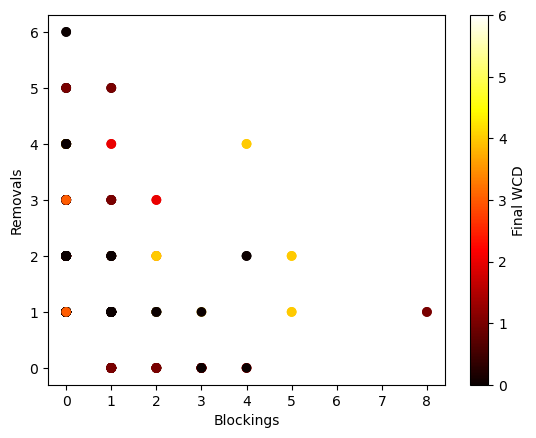

In [134]:
plt.scatter(blockings,removals, c=y_final_good, cmap='hot')
plt.xlabel("Blockings")
plt.ylabel("Removals")
# Adding a color bar to interpret the budget values
plt.colorbar(label='Final WCD')

In [135]:
# worsened environments
x_final_bad = x_final_data[y_final_data>y_init_data]
y_final_bad = y_final_data[y_final_data>y_init_data]

x_init_bad = x_init_data[y_final_data>y_init_data]
y_init_bad = y_init_data[y_final_data>y_init_data]
y_init_bad.shape[0]/y_init_data.shape[0]

0.049079754601226995

In [136]:
# neutral environments
x_final_neutral = x_final_data[y_final_data==y_init_data]
y_final_neutral = y_final_data[y_final_data==y_init_data]

x_init_neutral = x_init_data[y_final_data==y_init_data]
y_init_neutral = y_init_data[y_final_data==y_init_data]
y_init_neutral.shape[0]/y_init_data.shape[0]

0.6857532379004772

In [137]:
def display_init_final(x_init,y_init,x_final,y_final, start_from_idx =0, display_interval = 10):
    for idx in range(start_from_idx,x_init.shape[0],display_interval):
        
        x_i = x_init[idx]
        x_k = x_final[idx]
        x_changes = x_k[1, :, :]-x_i[1, :, :]
        
        blockings = (x_changes==1).sum()
        removals = (x_changes==-1).sum()
        if removals> 0 and blockings>0:
            print(idx)
            print("Init true WCD = ",y_init[idx],"Pred WCD: ",round(model(torch.tensor(x_i).unsqueeze(0).cuda()).item(),2))
            plot_grid(decode_grid_design(x_i,return_map= True).tolist())




            print("Final WCD = ",y_final[idx],"Pred WCD: ",round(model(torch.tensor(x_k).unsqueeze(0).cuda()).item(),2), "Num changes",blockings+removals,[blockings,removals])
            plot_grid(decode_grid_design(x_k,return_map= True).tolist())

            print("\n =========================")


In [138]:
display_init_final(x_init_good,y_init_good,x_final_good,y_final_good, start_from_idx =10, display_interval = 2)

10
Init true WCD =  4.0 Pred WCD:  4.66


NameError: name 'decode_grid_design' is not defined

In [ ]:
display_init_final(x_init_bad,y_init_bad,x_final_bad,y_final_bad, start_from_idx =0, display_interval = 10) 

In [ ]:
display_init_final(x_init_neutral,y_init_neutral,x_final_neutral,y_final_neutral, start_from_idx =0, display_interval = 10)

NameError: name 'np' is not defined